1) Import Libraries and Datsets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

IMG_WIDTH = 151
IMG_HEIGHT = 136
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 30

TRAIN_DIR = r"C:\Users\User\OneDrive\Documents\Malaria detection\Dataset\Train"
TEST_DIR = r"C:\Users\User\OneDrive\Documents\Malaria detection\Dataset\Test"


2) Data Loading and Preprocessing

In [3]:
def load_image_dataset(directory, img_width, img_height, batch_size, shuffle=True):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory=directory,
        shuffle=shuffle,
        image_size=(img_width, img_height),
        batch_size=batch_size
    )

train_data = load_image_dataset(TRAIN_DIR, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE)
test_data = load_image_dataset(TEST_DIR, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE)
class_names = train_data.class_names

Found 416 files belonging to 2 classes.
Found 134 files belonging to 2 classes.


3) Visualization

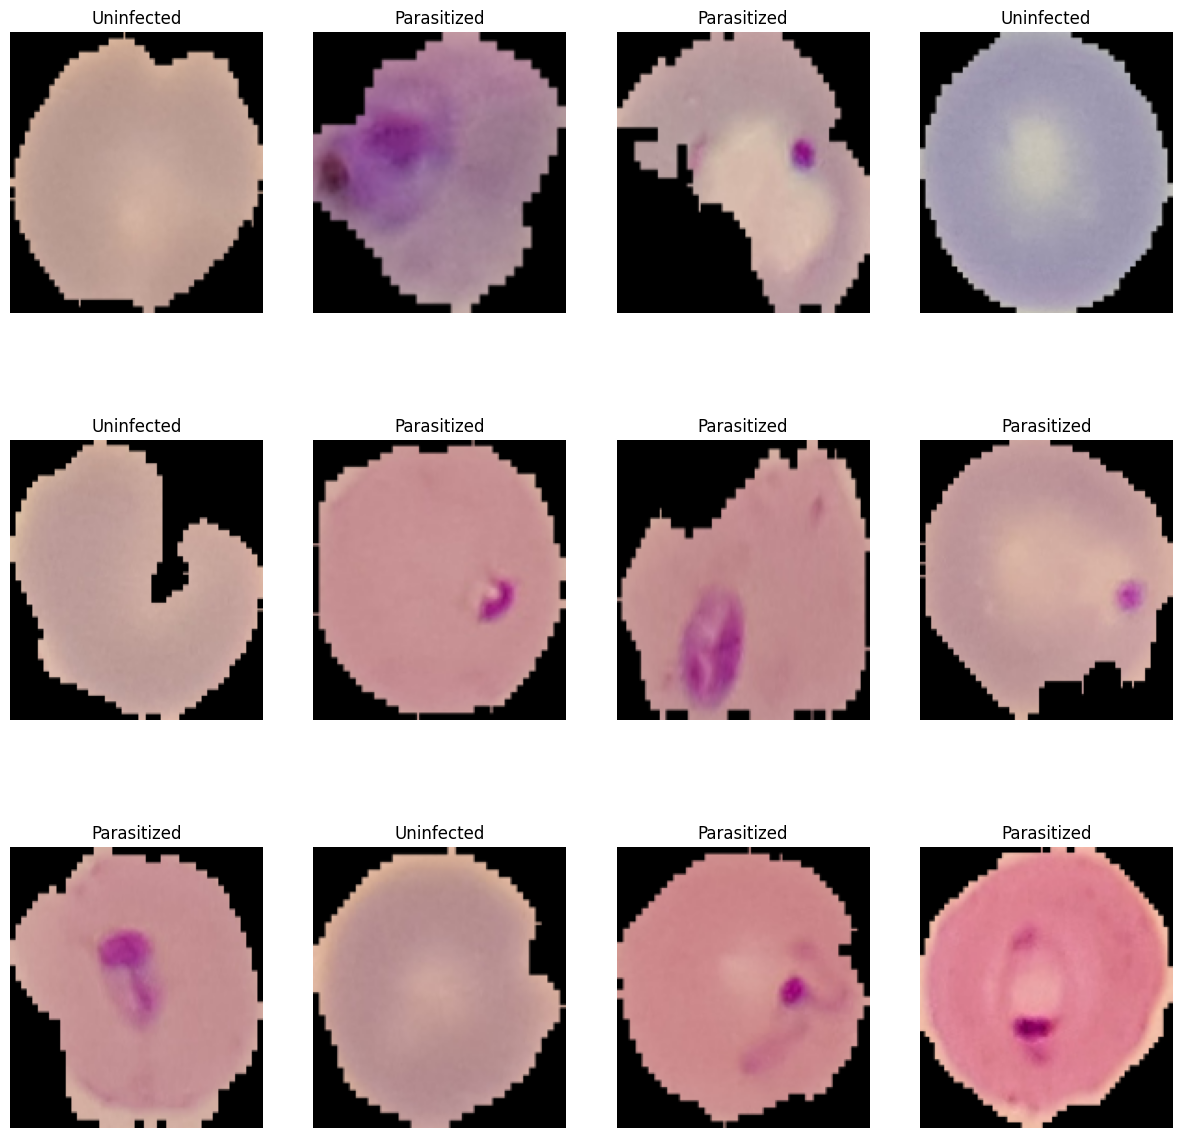

In [4]:
def plot_sample_images(dataset, class_names, samples=12):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(samples):
            plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.show()

plot_sample_images(train_data, class_names)

4) Splitting of Data
Training Set : 85%
Validation Set : 15%

In [5]:
def split_dataset(dataset, split_ratio=0.85, shuffle_buffer=1000):
    dataset = dataset.shuffle(shuffle_buffer, seed=42)
    total = len(dataset)
    train_size = int(total * split_ratio)
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size)
    return train_ds, val_ds

train_ds, val_ds = split_dataset(train_data)

5) Performance Optimization

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds):
    return ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)

train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)
test_ds = prepare_dataset(test_data)

6) Data Augmentation

In [7]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_WIDTH, IMG_HEIGHT),
    layers.Rescaling(1./255)
])

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.1)
])

7) Model Architecture

In [8]:
def build_cnn_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)):
    model = models.Sequential([
        resize_rescale,
        augment,
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_cnn_model()


8) Training

In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/30
11/11 [==============================] - 42s 3s/step - loss: 0.7562 - accuracy: 0.5227 - val_loss: 0.6838 - val_accuracy: 0.5938
Epoch 2/30
11/11 [==============================] - 26s 2s/step - loss: 0.6957 - accuracy: 0.4489 - val_loss: 0.6897 - val_accuracy: 0.5938
Epoch 3/30
11/11 [==============================] - 27s 2s/step - loss: 0.6935 - accuracy: 0.5114 - val_loss: 0.6873 - val_accuracy: 0.5938
Epoch 4/30
11/11 [==============================] - 27s 2s/step - loss: 0.6882 - accuracy: 0.5199 - val_loss: 0.6499 - val_accuracy: 0.5938
Epoch 5/30
11/11 [==============================] - 26s 2s/step - loss: 0.6859 - accuracy: 0.5398 - val_loss: 0.6476 - val_accuracy: 0.6875
Epoch 6/30
11/11 [==============================] - 28s 3s/step - loss: 0.6198 - accuracy: 0.6790 - val_loss: 0.7422 - val_accuracy: 0.4844
Epoch 7/30
11/11 [==============================] - 26s 2s/step - loss: 0.5967 - accuracy: 0.7273 - val_loss: 0.5789 - val_accuracy: 0.7188
Epoch 8/30
11/11 [==

9) Evaluation and Visualization

5/5 [==============================] - 3s 476ms/step - loss: 0.1535 - accuracy: 0.9478
Test Accuracy: 0.95


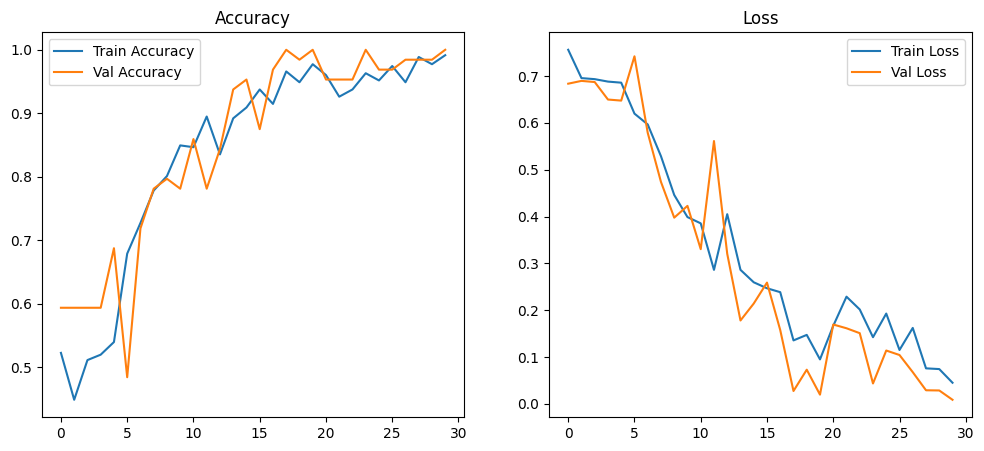

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [11]:
def predict_image(model, img, class_names):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    pred = model.predict(img_array)[0][0]
    pred_class = class_names[1] if pred > 0.5 else class_names[0]
    confidence = np.round(max(pred, 1-pred) * 100, 2)
    return pred_class, confidence

10) Predictions

1/1 [==============================] - 0s 53ms/step


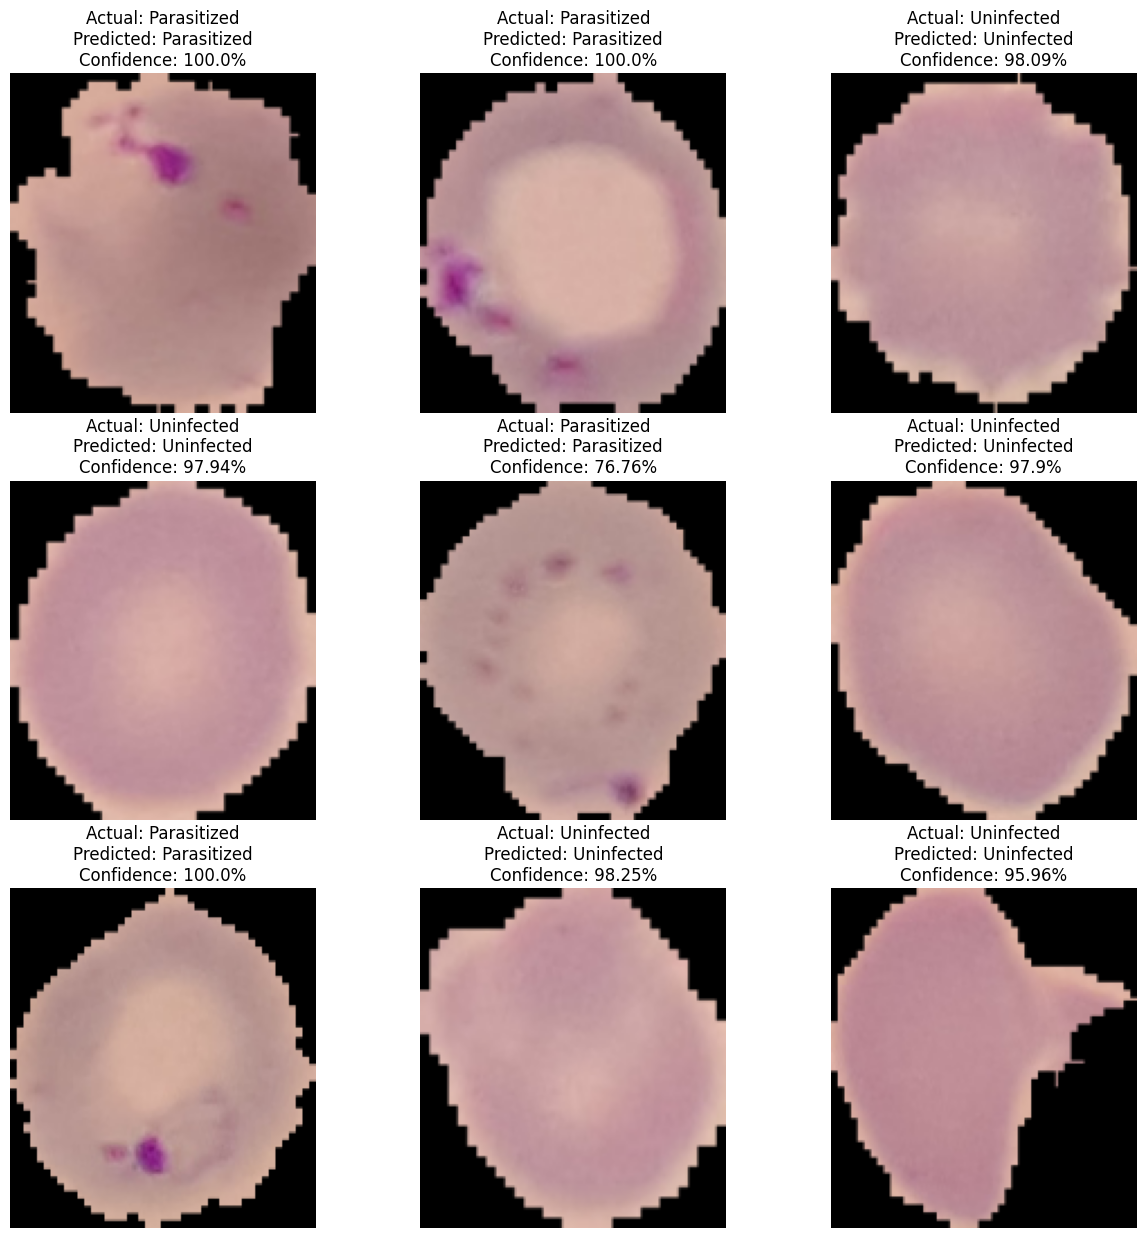

In [12]:
def show_predictions(model, dataset, class_names, samples=9):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(samples):
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy().astype("uint8")
            pred_class, confidence = predict_image(model, images[i], class_names)
            actual_class = class_names[labels[i]]
            plt.imshow(img)
            plt.title(f"Actual: {actual_class}\nPredicted: {pred_class}\nConfidence: {confidence}%")
            plt.axis("off")
    plt.show()

show_predictions(model, test_ds, class_names)

In [13]:
model.save("malaria_model.h5")